### Different example uses for ColorCube

In [27]:
import os, sys, copy, random
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from modules.Interproc import DBInterface
from modules.Interproc import GuiviewState

In [4]:
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.imgutils import (filter_pixels_circle
                              ,crop_img
                             )

In [5]:
from modules.AnalysisHelpers import ( imgToColors
                                     ,channelsToColorStr
                                     ,cvtPlot
                                    )
from modules.AnalysisHelpers import colorCube
from modules.AnalysisHelpers import SubprocColorCube
from modules.AnalysisHelpers import subprocColorCube

from modules.AnalysisHelpers import (threshToEdges
                                     ,pointsToList
                                    )

from modules.AnalysisHelpers import PixelConfusionMatrix

##### Load Book Data

In [6]:
DATA_DIR = "../data/misc/books/cc-gallery-2/"

In [7]:
gsDb = DBInterface(os.path.join(DATA_DIR,"interproc.db"))
all_data = gsDb.selectAll()
listGS = [ pickle.loads(d[1]) for d in all_data]
                
[_gs.frameCounter for _gs in listGS]

[0, 0, 0, 0, 189, 256]

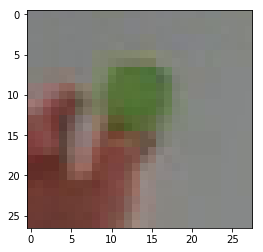

In [9]:
for _gs in listGS:
    _gs.initDisplay()
    cvtPlot(_gs.getZoomWindow())
#     plt.show()

##### Build thresh region volume

In [10]:
tracker = TrackFactory()
tracker.setInit(ballColor="green")

threshLo = tracker.getTrackParams()['thresh_lo']
threshHi = tracker.getTrackParams()['thresh_hi']

print threshLo, threshHi

(29, 86, 6) (64, 255, 255)


In [11]:
plotEdges = pointsToList(threshToEdges(threshLo, threshHi, stepAmt = 10))

In [12]:
img = listGS[0].getZoomWindow()
colorData = imgToColors(img, sampleN = 1000)
listB, listG, listR = colorData

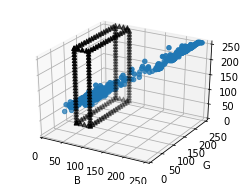

In [15]:
#subprocColorCube(listB, listG, listR, regionMarkers = plotEdges)
colorCube(listB, listG, listR, regionMarkers = plotEdges, figsize = (4,3))

### Confusion Matrix Colorcoded

In [110]:
from modules.AnalysisHelpers import PixelConfusionMatrix
from modules.ControlTracking import TrackFactory

In [111]:
tracker = TrackFactory()
tracker.setInit(ballColor="green")

threshLo = tracker.getTrackParams()['thresh_lo']
threshHi = tracker.getTrackParams()['thresh_hi']

print threshLo, threshHi

(29, 86, 6) (64, 255, 255)


In [112]:
pcm = PixelConfusionMatrix()

In [113]:
pcm.setImg(listGS[0].getOrigFrame())

In [114]:
thresh = (
             tracker.getTrackParams()['thresh_lo']
            ,tracker.getTrackParams()['thresh_hi']
        )
pcm.setThresh(thresh)

In [115]:
pcm.setCircle(listGS[3].displayOutputScore['0']['data'])

In [116]:
pcm.calc()

In [117]:
pcm.getVals()

{'N': 307200,
 'f': 305683,
 'fn': 855,
 'fp': 27,
 'n': 306511,
 'p': 689,
 't': 1517,
 'tn': 305656,
 'tp': 662}

In [118]:
pcm.displayVals()

                                         True          False
                        307200           1517         305683
       Positive            689            662             27
       Negative         306511         305656            855


In [119]:
pcm.displayVals(bN=False)

                                         True          False
                           1.0       0.004938       0.995062
       Positive       0.002243       0.002155        8.8e-05
       Negative       0.997757       0.994974       0.002783


In [28]:
cm = pcm.getData()

In [29]:
metrics = ['tp', 'fp', 'fn', 'tn']
N = 1000

plotData = {}
for metric in metrics:
    _data = cm[metric]
    plotData[metric] = pointsToList(
                        random.sample(_data, min(len(_data), N))
                         )

In [30]:
def confusionData(gs, inputThresh, N = 1000):

    _img = gs.getOrigFrame()
    _circle = gs.displayOutputScore['0']['data']
    _thresh = inputThresh

    #build confusion data
    pcm = PixelConfusionMatrix( img = _img
                               ,thresh = _thresh
                               ,circle = _circle
                              )
    pcm.calc()

    cm = pcm.getData()

    metrics = ['tp', 'fp', 'fn', 'tn']
    plotData = {}

    for metric in metrics:
        _data = cm[metric]
        plotData[metric] = pointsToList(
                        random.sample(_data, min(len(_data), N))
                         )
    return plotData

In [31]:
def confusionPlotByImage(listGS, 
                         inputThresh, 
                         N = 1000, 
                         viewPositionDefined = {}
                        ):
    ''' across each guiview-state, plot a color cube
    
        thresh held constant
    '''
    
    for _gs in listGS:
        
        _img = _gs.getOrigFrame()
        _circle = _gs.displayOutputScore['0']['data']
        _thresh = inputThresh
        
        #build confusion data
        pcm = PixelConfusionMatrix( img = _img
                                   ,thresh = _thresh
                                   ,circle = _circle
                                  )
        pcm.calc()
        
        cm = pcm.getData()
        
        metrics = ['tp', 'fp', 'fn', 'tn']
        plotData = {}
        
        for metric in metrics:
            _data = cm[metric]
            plotData[metric] = pointsToList(
                            random.sample(_data, min(len(_data), N))
                             )
        
        #build regionMarkers
        _regionMarkers = pointsToList(
                            threshToEdges(
                                _thresh[0]
                                ,_thresh[1]
                                , stepAmt = 10
                            )
                        )
        
        _title = 'frame ' + str(_gs.frameCounter)
        
        colorCube(confData = plotData
                 ,regionMarkers = _regionMarkers
                  ,viewPositionDefined = viewPositionDefined
                  ,bInitPosition = True
                 ,title = _title
                 )
        
        
#         plt.show()

In [32]:
_viewPositionDefined = {'azimuth': -81,'elevation': 95}

##### Show for each Frame, 189 - is noTrack and it shows

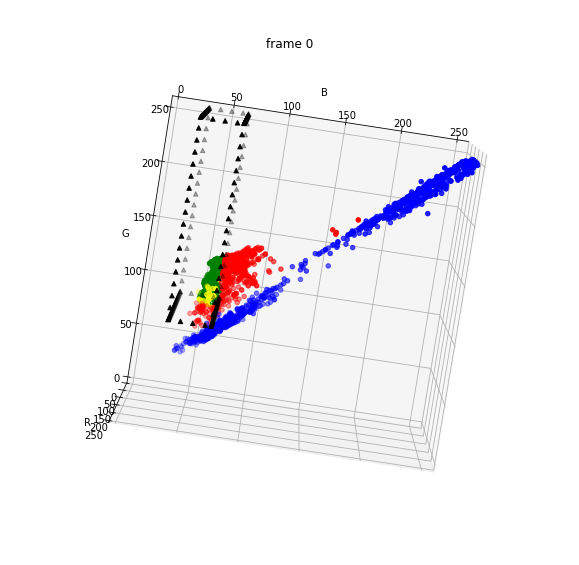

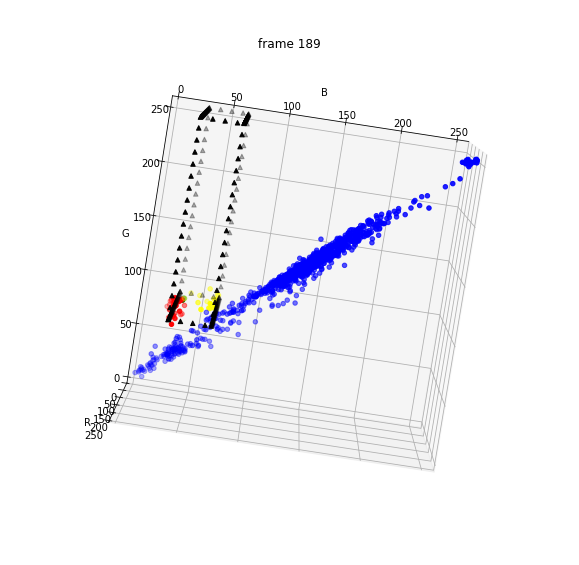

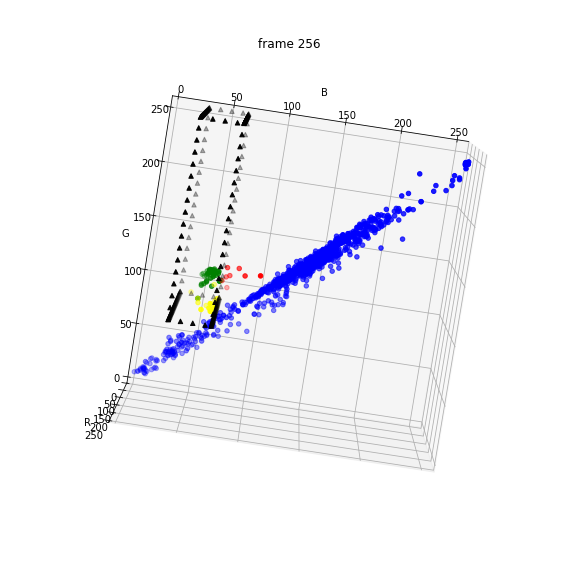

In [34]:
confusionPlotByImage(listGS[3:], thresh, 
                     viewPositionDefined = _viewPositionDefined)

In [35]:
[ x.displayOutputScore for x in listGS]

[None,
 None,
 None,
 {'0': {'data': (203, 161, 47, 44), 'type': 'circle'}},
 {'0': {'data': (289, 421, 9, 10), 'type': 'circle'}},
 {'0': {'data': (320, 223, 10, 9), 'type': 'circle'}}]

In [36]:
from modules.AnalysisHelpers import colorCube
from modules.AnalysisHelpers import SubprocColorCube
from modules.AnalysisHelpers import subprocColorCube

#### Explore Frame 189, first with non-interactive and not a good-view

In [37]:
thresh

((29, 86, 6), (64, 255, 255))

In [38]:
myPlotData = confusionData(listGS[4], thresh, N=1000)

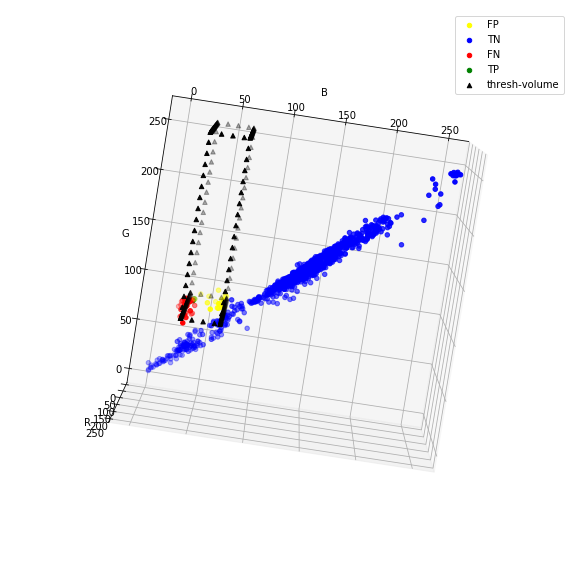

In [39]:
colorCube( confData = myPlotData
          ,regionMarkers = plotEdges 
          ,viewPositionDefined = {'azimuth': -81,'elevation': 95}
          ,bInitPosition=True
          ,spaceTotal=False
          ,bLegend = True)

subprocColorCube( confData = myPlotData
          ,regionMarkers = plotEdges 
#           ,viewPositionDefined = {'azimuth': -81,'elevation': 95}
#           ,bInitPosition=True
          ,spaceTotal=False
#           ,bLegend = True
                )


#### Frame189 bigdata plot

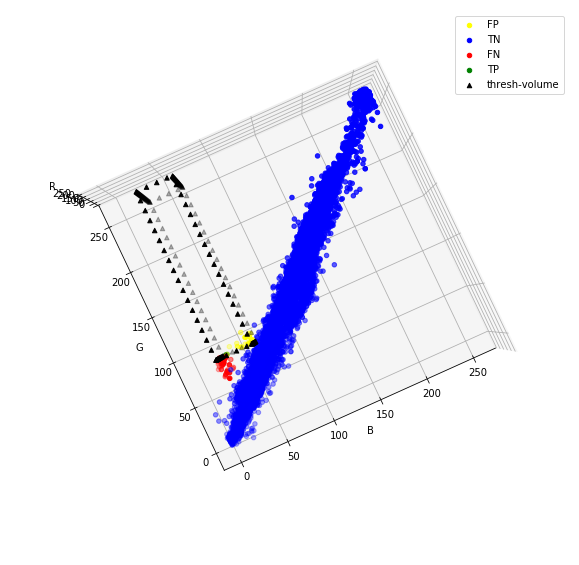

In [40]:
bigPlotData = confusionData(listGS[4], thresh, N=30000)
q = (89.24381848352289, -114.81290322580614)

colorCube( confData = bigPlotData
          ,regionMarkers = plotEdges 
          ,viewPositionDefined = {'azimuth': q[1],'elevation': q[0]}
          ,bInitPosition=True
          ,spaceTotal=False
          ,bLegend = True)

#### Interesting Cross Section Views

loaded class type:  SubprocColorCube


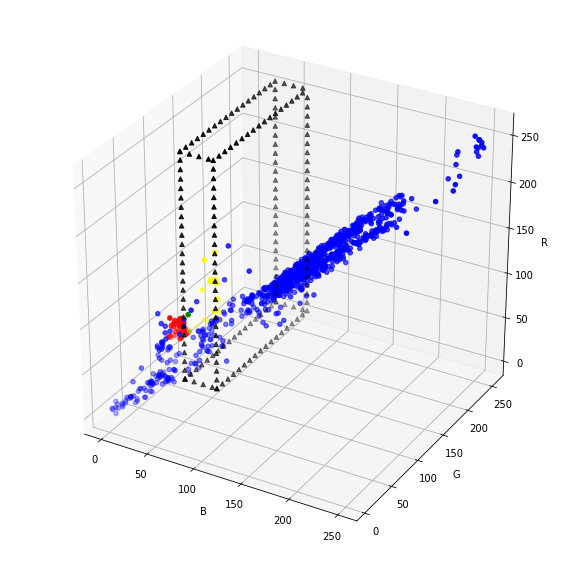

In [41]:
p2 = SubprocColorCube()
p2.load()
p2.callPlot()

In [431]:
p2.loadedClass.elevation, p2.loadedClass.azimuth

(89.24381848352289, -114.81290322580614)

loaded class type:  SubprocColorCube


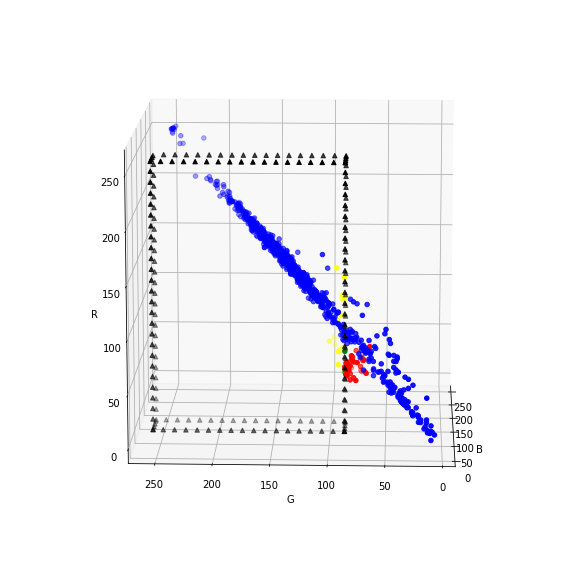

In [429]:
p3 = SubprocColorCube()
p3.load()
p3.callPlot()

In [434]:
p3.loadedClass.elevation, p3.loadedClass.azimuth

(12.473703698624547, -177.98709677419325)

In [ ]:
#good head on view: 138.8 , 47.03
#good red+green: -166. , -3.57
#good green+blue {'azimuth': -81,'elevation': 95}
#good red+blue:  80.74 , 145.7


#### Multiple Views Function

In [120]:
def multiViewColorCube(confusionData, title=""):
    
    views = [
         ('green+blue' , {'azimuth': -81,'elevation': 95})
        ,('green+red' ,  {'azimuth': -166,'elevation': -3.57})
        ,('red+blue' ,   {'azimuth': 81,'elevation': 145})
    ]
    
    _regionEdges = 
    
    for _view in views:
    
        _title = _view[0] + str(title)
    

        colorCube( confData = confusionData 
                  ,viewPositionDefined = _view[1]
                  ,bInitPosition = True
                  ,regionMarkers = plotEdgesTotal
                  ,title = _title
                 )

In [125]:
plotData = confusionData(listGS[3], thresh)

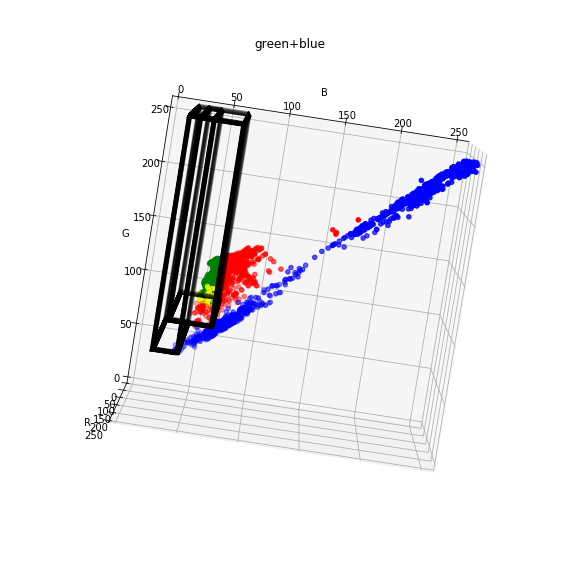

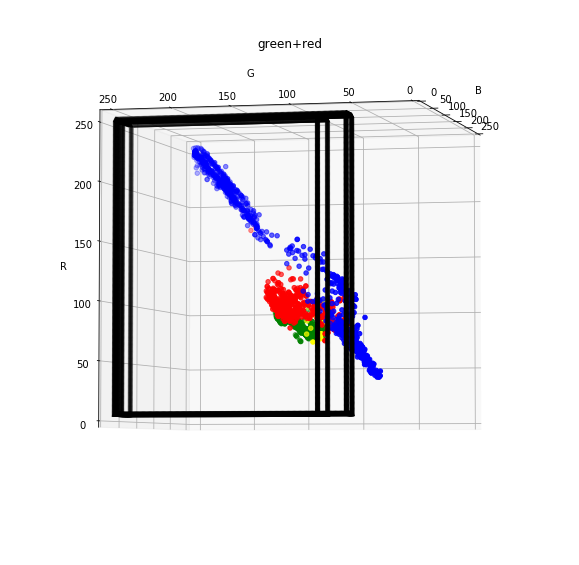

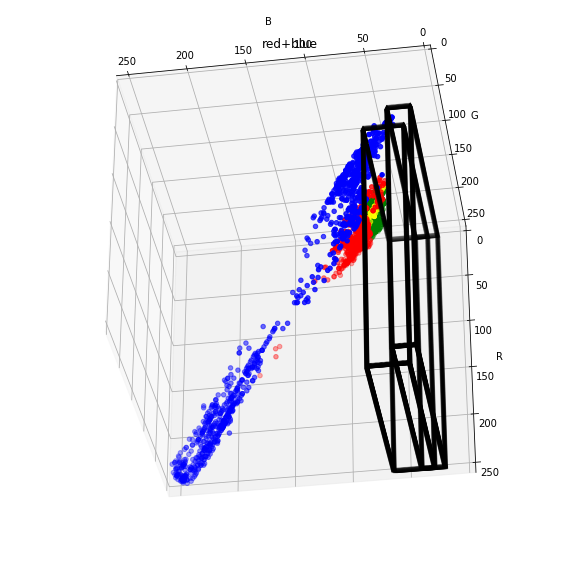

In [126]:
multiViewColorCube(plotData)

In [121]:
thresh

((29, 86, 6), (64, 255, 255))

#### Add second thresh

In [42]:
tracker = TrackFactory()
tracker.setInit(ballColor="green")

threshLo = tracker.getTrackParams()['thresh_lo']
threshHi = tracker.getTrackParams()['thresh_hi']

print threshLo, threshHi

(29, 86, 6) (64, 255, 255)


In [43]:
plotEdges = pointsToList(threshToEdges(threshLo, threshHi, stepAmt = 1))

In [44]:
volume2 = ((20,60, 6),(64,255,255))

In [45]:
volume2 = ((20,60, 6),(40,255,255))

In [46]:
plotEdges2 = pointsToList(threshToEdges(volume2[0], volume2[1], stepAmt = 1))

In [47]:
plotEdgesTotal = []
for a,b in zip(plotEdges, plotEdges2):
    _data = a
    _data.extend(b)
    plotEdgesTotal.append(_data)

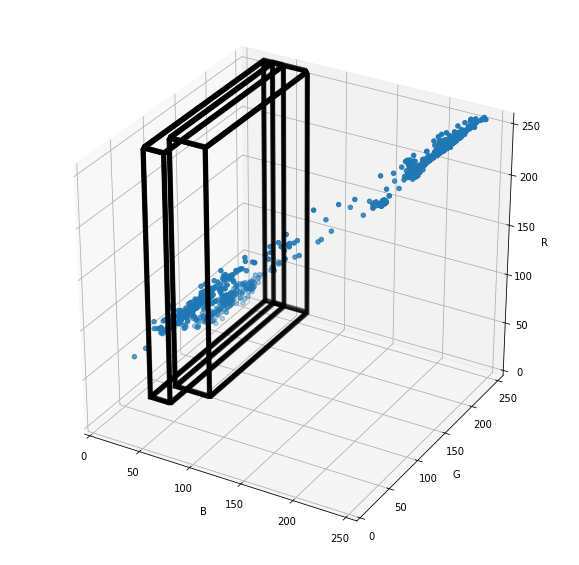

In [48]:
img = listGS[0].getZoomWindow()
colorData = imgToColors(img, sampleN = 1000)
listB, listG, listR = colorData

colorCube(listB, listG, listR, regionMarkers = plotEdgesTotal)

In [49]:
from modules.AnalysisHelpers import colorCube
from modules.AnalysisHelpers import SubprocColorCube
from modules.AnalysisHelpers import subprocColorCube

from modules.AnalysisHelpers import (threshToEdges
                                     ,pointsToList
                                    )

from modules.AnalysisHelpers import PixelConfusionMatrix

####  2 threshes run into confusion Matrix

In [50]:
gs = listGS[4]

_img = gs.getOrigFrame()
_circle = gs.displayOutputScore['0']['data']
_thresh = [thresh, volume2]

#build confusion data
pcm = PixelConfusionMatrix( img = _img
#                             ,thresh = thresh
                           ,threshes = _thresh
                           ,circle = _circle
                          )
pcm.calc()

cm = pcm.getData()

metrics = ['tp', 'fp', 'fn', 'tn']
plotData = {}

for metric in metrics:
    _data = cm[metric]
    plotData[metric] = pointsToList(
                    random.sample(_data, min(len(_data), N))
                     )

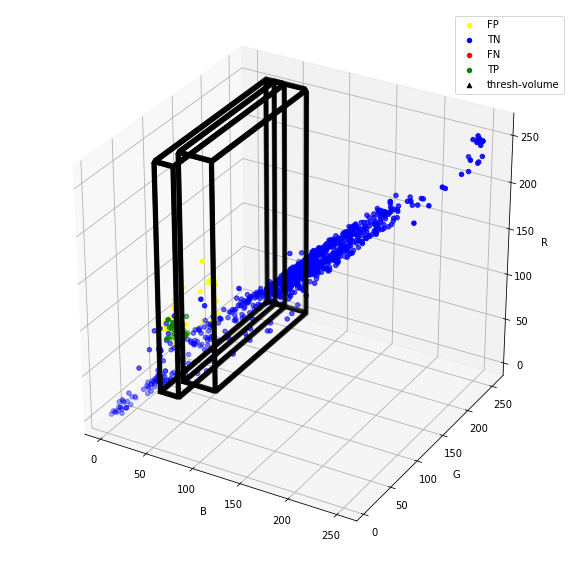

In [51]:
colorCube( confData = plotData
          ,regionMarkers = plotEdgesTotal 
#           ,viewPositionDefined = {'azimuth': -81,'elevation': 95}
          ,viewPositionDefined = {'azimuth': p2.loadedClass.azimuth,
                                  'elevation': p2.loadedClass.elevation}
          ,bInitPosition=True
          ,spaceTotal=False
          ,bLegend = True)

subprocColorCube( confData = plotData
          ,regionMarkers = plotEdgesTotal 
#           ,viewPositionDefined = {'azimuth': -81,'elevation': 95}
#           ,bInitPosition=True
          ,spaceTotal=False
#           ,bLegend = True
         )

In [529]:
pcm.getVals()

{'N': 307083,
 'f': 307151,
 'fn': 0,
 'fp': 68,
 'n': 307083,
 'p': 117,
 't': 49,
 'tn': 307083,
 'tp': 49}